# Weighted ECM clustering vs Traditional ECM clustering
## With Seeds dataset


In [1]:
## Importing
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
from evclust.ecm import ecm
from evclust.wecm_new import wecm
from evclust.utils import ev_summary, ev_pcaplot, calculate_non_specificity, ev_plot_PCA, plotting
import pandas as pd
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from evclust.datasets import load_seeds


      A     B    D    E    F    G
0  15.0  15.0  6.0  3.0  2.0  5.0
1  15.0  15.0  6.0  3.0  1.0  5.0
2  14.0  14.0  5.0  3.0  3.0  5.0
3  14.0  14.0  5.0  3.0  2.0  5.0
4  16.0  15.0  6.0  4.0  1.0  5.0


D:\vtdo\projects\evclust\src\evclust\utils.py:1085: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data_reduced[i, 0], data_reduced[i, 1], alpha=0.5, c=colors[i], marker=marker_list[i])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


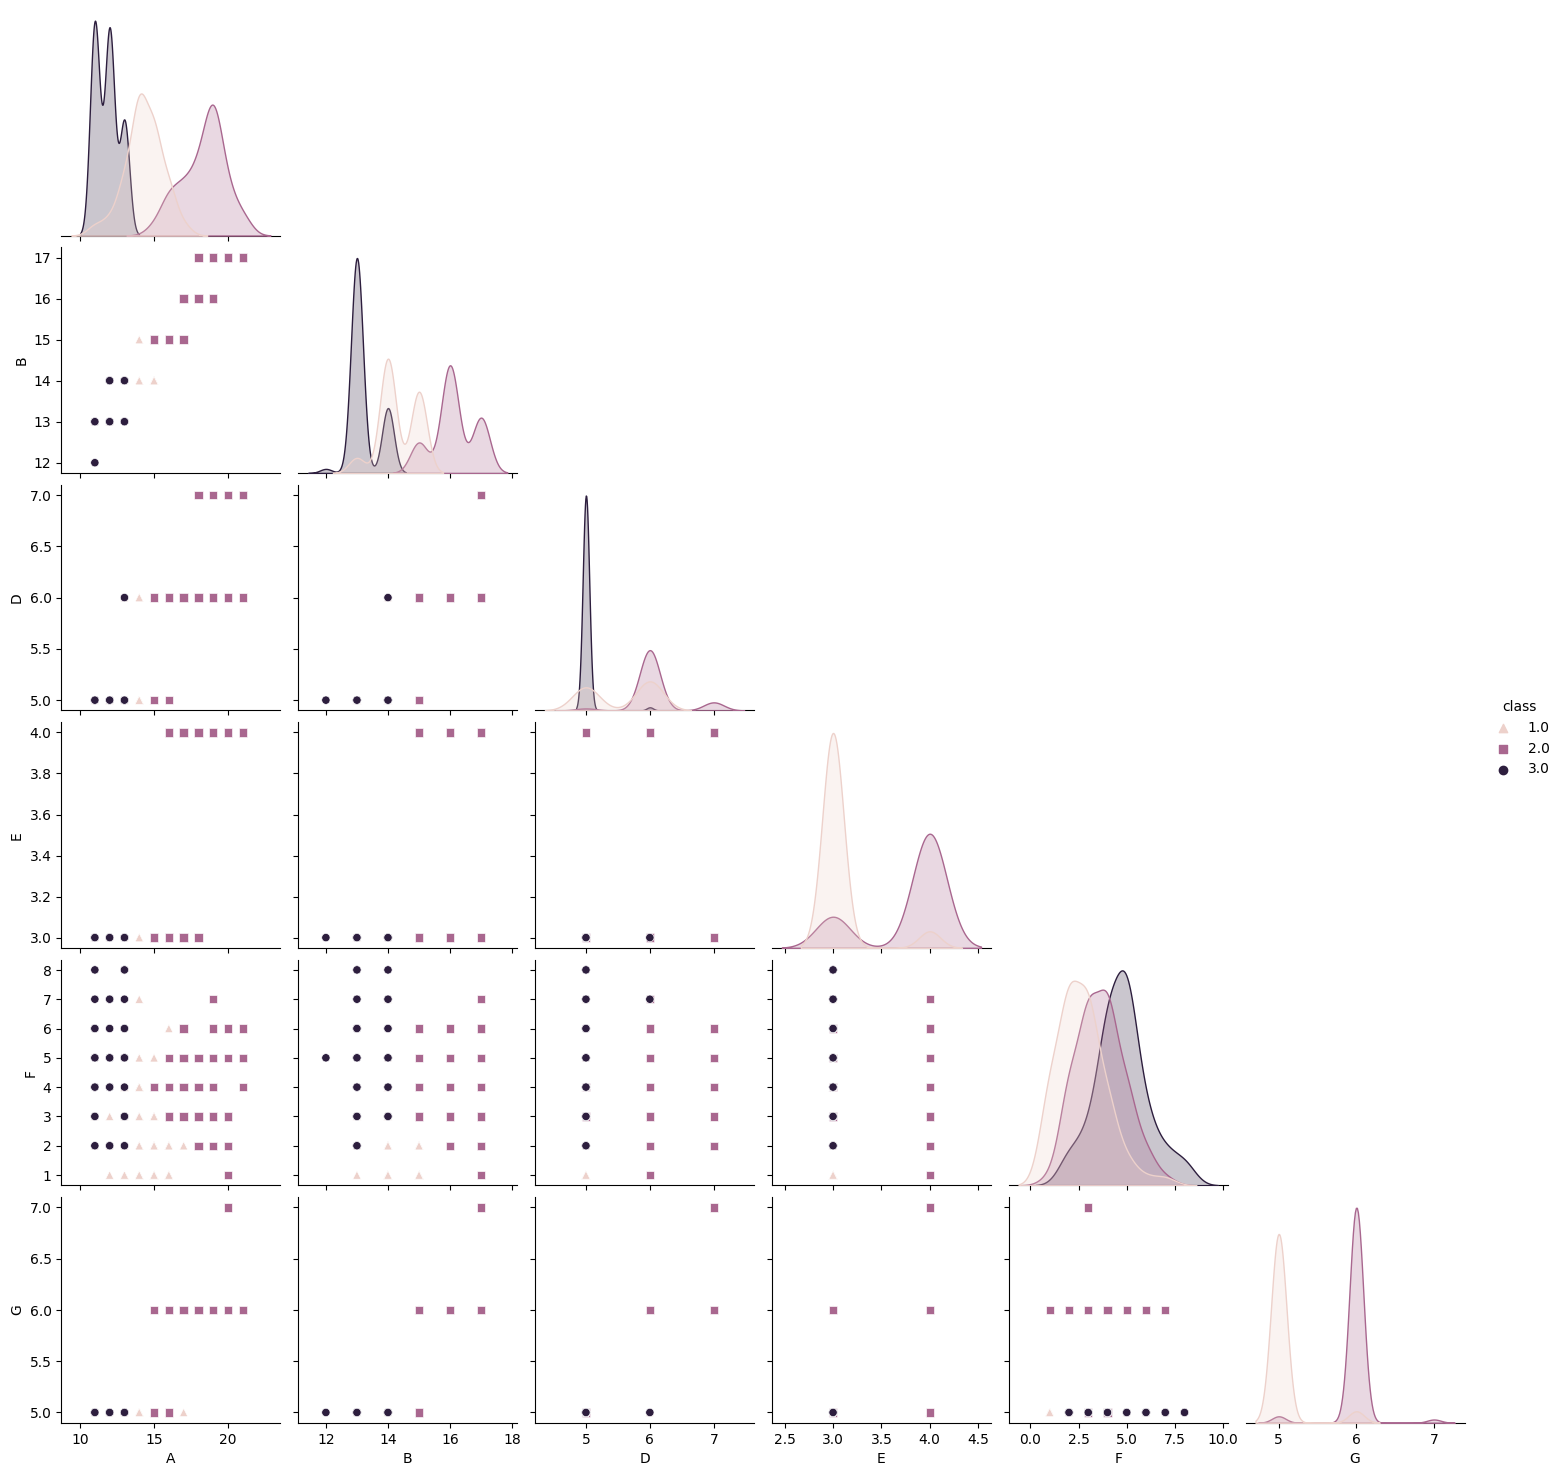

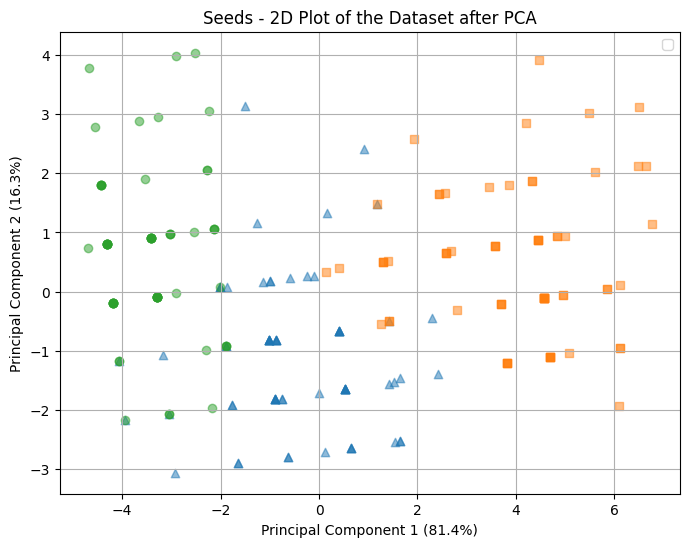

In [2]:
# fetch dataset
df = load_seeds()
df = df.drop(columns=['C'])  # all value equal 1
# data (as pandas dataframes)
y = pd.DataFrame(df.iloc[:, -1])
X = df.iloc[:, :-1]

label_column_nm = y.columns[0]
labels_encoder = LabelEncoder()
numeric_labels = labels_encoder.fit_transform(y[label_column_nm])

markers = ['^', 's', 'o']
plotting(X, y, ds_name="Seeds", matrix_plot=True, markers=markers)

# Normalization
scaler = MinMaxScaler((0,1))
X = pd.DataFrame(scaler.fit_transform(X))

## Traditional ECM

In [3]:
# Traditional ECM clustering
delta = np.sqrt(20)
model = ecm(x=X, c=3, beta=2, alpha=1, delta=delta, ntrials=10)

# Compute the Adjusted Rand Index (ARI)
true_labels = numeric_labels
Y_betP = model['betp']
predicted_labels = np.argmax(Y_betP, axis=1)

ari = adjusted_rand_score(true_labels, predicted_labels)
print("----------Traditional ECM----------")
print(f"Jbest: {model['crit']}")
print(f"Centers: \n {model['g']}")

print(f"Adjusted Rand Index (ARI): {ari}")

# Calculate Non-specificity
calculate_non_specificity(model)

[1, 11.165377166618235]
[2, 10.823004251810357]
[3, 10.70024939041087]
[4, 10.663189956830388]
[5, 10.653907426123391]
[6, 10.651590016946033]
[7, 10.650994305997546]
[ 0.         10.65099431 10.65099431]
[1, 11.165377166618235]
[2, 10.823004251810357]
[3, 10.70024939041087]
[4, 10.66318995683039]
[5, 10.653907426123391]
[6, 10.651590016946033]
[7, 10.650994305997546]
[ 1.         10.65099431 10.65099431]
[1, 11.165377166618235]
[2, 10.823004251810357]
[3, 10.700249390410871]
[4, 10.663189956830388]
[5, 10.653907426123391]
[6, 10.651590016946034]
[7, 10.650994305997546]
[ 2.         10.65099431 10.65099431]
[1, 11.165377166618235]
[2, 10.823004251810357]
[3, 10.700249390410871]
[4, 10.663189956830388]
[5, 10.653907426123391]
[6, 10.651590016946034]
[7, 10.650994305997546]
[ 3.         10.65099431 10.65099431]
[1, 11.165377166618235]
[2, 10.823004251810357]
[3, 10.70024939041087]
[4, 10.66318995683039]
[5, 10.653907426123391]
[6, 10.651590016946033]
[7, 10.650994305997546]
[ 4.         

1.1254592826479568

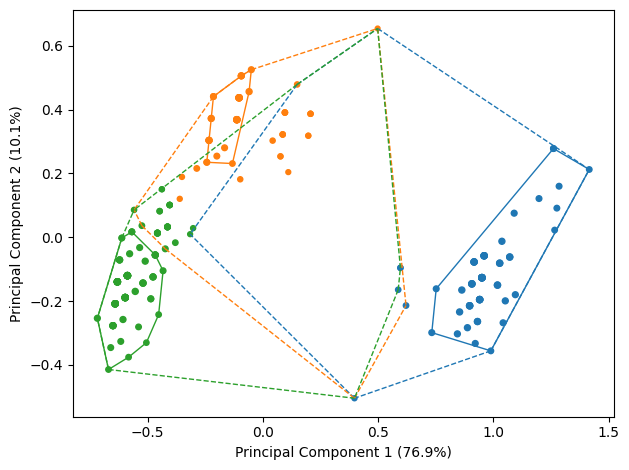

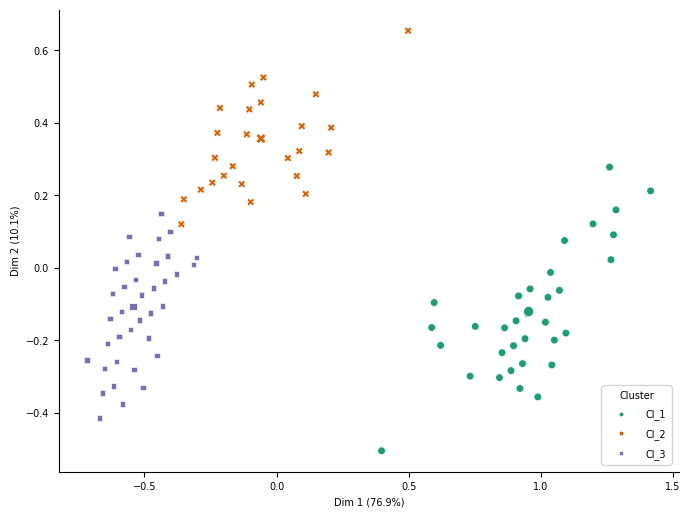

In [4]:
# Plots
ev_plot_PCA(model, X=X, cex=20)
ev_pcaplot(data=X, x=model, normalize=False, cex=30)

## Weighted ECM (W ECM)

In [5]:
# Feature weighted ECM clustering
# W = np.array([
#     [0.07197209, 0.51605783, 0.11821111, 0.20893455, 0.01398744, 0.07083698],
#     [0.06738635, 0.02027021, 0.35386533, 0.02805789, 0.12012324, 0.41029698],
#     [0.0410078, 0.1919464, 0.01633889, 0.22999487, 0.18923781, 0.33147423]
# ])
model_list = np.array([])
for i in range(30):
    c = 3
    delta = np.sqrt(20)
    model = wecm(x=X, c=c, W=None, beta=2, alpha=1, delta=delta, ntrials=10, epsi=1e-3)
    model_list = np.append(model_list, model)
    
# Get best 10 models with minimum values
num = 10
model_list = sorted(model_list, key=lambda x : x['crit'])
print([x['crit'] for x in model_list])
top_weights = [model['W'] for model in model_list[:num]]

# Get ARI values of top 10
true_labels = numeric_labels
predicted_labels_list = [np.argmax(model['betp'], axis=1) for model in model_list[:num]]
top_aris = [adjusted_rand_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]
print(f"ARIs: {top_aris}")

# Non-specificity values of top 10
top_NS = [calculate_non_specificity(model, verbose=False) for model in model_list[:num]]
print(f"Non-specificities: {top_NS}")

Initial weights: 
 [[0.16053497 0.39461136 0.02585995 0.03639766 0.02086879 0.36172726]
 [0.14208033 0.04487132 0.22016557 0.26313386 0.02062215 0.30912677]
 [0.00080561 0.05627012 0.14477852 0.40978957 0.08972989 0.2986263 ]]
---------Iteration #1---------
Initial prototypes: 
 [[0.765      0.84       0.55       1.         0.33333333 0.46666667]
 [0.13267327 0.28316832 0.         0.         0.4427157  0.        ]
 [0.42653061 0.5755102  0.51020408 0.         0.32069971 0.17346939]]
[1, 0.27356485650503404]
[2, 0.24454350989760046]
[3, 0.23605749497125678]
[4, 0.23520553768405714]
[0.         0.23520554 0.23520554]
---------End Iteration #1---------
---------Iteration #2---------
Initial prototypes: 
 [[0.42653061 0.5755102  0.51020408 0.         0.32069971 0.17346939]
 [0.765      0.84       0.55       1.         0.33333333 0.46666667]
 [0.13267327 0.28316832 0.         0.         0.4427157  0.        ]]
[1, 0.25518507768226867]
[2, 0.23173071653767668]
[3, 0.22516389195131933]
[4, 0.

----------Weighted ECM----------
Jbest: 0.12316642316024964
Centers: 
[[7.79056023e-01 8.46785538e-01 5.57600148e-01 1.00008710e+00
  3.20863219e-01 4.85735317e-01]
 [1.80770943e-01 3.32192709e-01 1.48274528e-01 6.38509953e-05
  4.03612636e-01 2.49651394e-04]
 [5.53411758e-01 6.79812701e-01 5.02644881e-01 1.03363447e-01
  4.36542611e-01 4.90159586e-01]]
Weights: 
[[0.0207065  0.02230344 0.07842716 0.56952861 0.20787179 0.1011625 ]
 [0.06801121 0.02333936 0.01998784 0.38034421 0.03449665 0.47382073]
 [0.18568464 0.0340562  0.4740324  0.08396762 0.11830304 0.10395611]]
Adjusted Rand Index (ARI) of the best J: 0.4312272473143956
Average ARI: 0.46584334719757353
Average Non-specificity: 0.9196448187854414


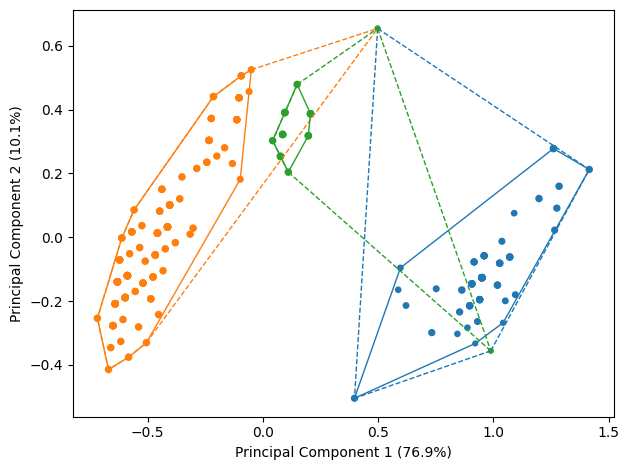

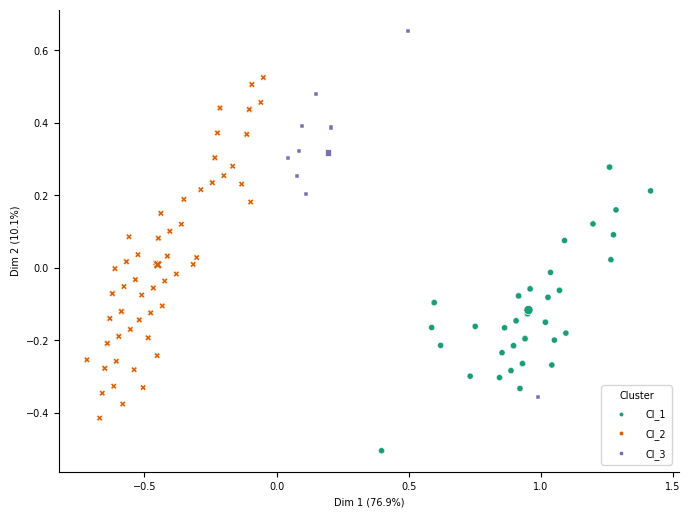

In [8]:
best_model = model_list[0]
print("----------Weighted ECM----------")
print(f"Jbest: {best_model['crit']}")
print(f"Centers: \n{best_model['g']}")
print(f"Weights: \n{best_model['W']}")
print(f"Adjusted Rand Index (ARI) of the best J: {top_aris[0]}")
print(f"Average ARI: {np.mean(top_aris)}")
print(f"Average Non-specificity: {np.mean(top_NS)}")

# Plotting PCA of the best model
ev_plot_PCA(best_model, X=X, cex=20)
ev_pcaplot(data=X, x=best_model, normalize=False, cex=20)

In [9]:
for W in top_weights:
    print(f"\n{W}")


[[0.0207065  0.02230344 0.07842716 0.56952861 0.20787179 0.1011625 ]
 [0.06801121 0.02333936 0.01998784 0.38034421 0.03449665 0.47382073]
 [0.18568464 0.0340562  0.4740324  0.08396762 0.11830304 0.10395611]]

[[0.24501248 0.20138837 0.09676006 0.07879916 0.00427803 0.37376191]
 [0.00742915 0.15983538 0.04610947 0.38088705 0.10759772 0.29814124]
 [0.33509544 0.39287972 0.02045303 0.04051022 0.09119586 0.11986573]]

[[0.18742503 0.26583896 0.26466547 0.09729409 0.01918513 0.16559132]
 [0.03486276 0.22865877 0.07921478 0.37183316 0.03082025 0.25461028]
 [0.27433354 0.32213416 0.03443759 0.0974986  0.10215435 0.16944177]]

[[0.08738101 0.23206914 0.06586022 0.03726835 0.08766207 0.4897592 ]
 [0.40999367 0.15641347 0.09846758 0.22456437 0.03939193 0.07116899]
 [0.07317443 0.03734025 0.56031608 0.00088993 0.30668952 0.02158978]]

[[0.16059628 0.39233191 0.02726802 0.03770035 0.02232677 0.35977666]
 [0.1423262  0.04608927 0.21963058 0.26216919 0.0220826  0.30770217]
 [0.00246422 0.05737408 0